<a href="https://www.kaggle.com/code/benfoglia/playground-3-17-machine-failure-classification?scriptVersionId=134388698" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Package Imports

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
import re
import warnings

# Data Exploration

In [2]:
# Read in datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")

train_df.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
train_df.isnull().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [4]:
# Drop unwanted columns
train_df = train_df.drop(columns=["id", 'Product ID'])

In [5]:
train_df.dtypes

Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

## Visualizations

/tmp/ipykernel_20/112718008.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df.corr()


<Axes: >

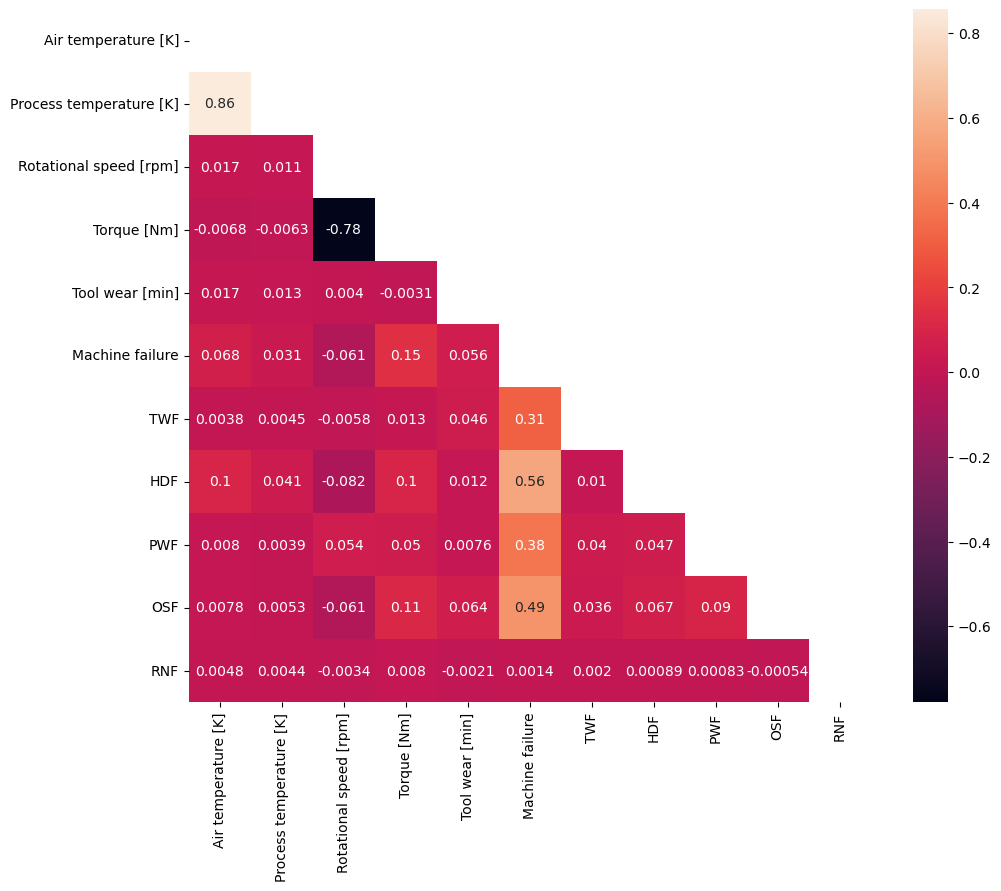

In [6]:
# Correlation

# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask = mask, annot=True, annot_kws={"fontsize":10})

## Categorical Variables

TWF, HDF, PWF, OSF have highest correlation with machine failure. Let's explore them further:

In [7]:
# Pull 4 columns highly correlated with machine failure
column_list = ['TWF', 'HDF', 'PWF', 'OSF']

# Create a Boolean condition based on the values in the four columns
condition = (train_df[column_list] == 1).any(axis=1)

# Select the desired columns using the Boolean condition
selected_data = train_df.loc[condition, column_list + ['Machine failure']]

# Count the occurrences of each unique combination of values
counts = selected_data.groupby(column_list + ['Machine failure']).size().reset_index(name='count').sort_values('Machine failure')

# Print the counts
print(counts[counts['count'] > 0])

    TWF  HDF  PWF  OSF  Machine failure  count
0     0    0    0    1                0      4
2     0    0    1    0                0      3
5     0    1    0    0                0      6
14    1    1    0    0                1      3
13    1    0    1    1                1      1
12    1    0    1    0                1      9
11    1    0    0    1                1     11
10    1    0    0    0                1    186
9     0    1    1    1                1      3
8     0    1    1    0                1     20
7     0    1    0    1                1     40
6     0    1    0    0                1    630
4     0    0    1    1                1     35
3     0    0    1    0                1    255
1     0    0    0    1                1    445
15    1    1    0    1                1      1
16    1    1    1    0                1      1


In [8]:
train_df.dtypes

Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

## Numeric Variables

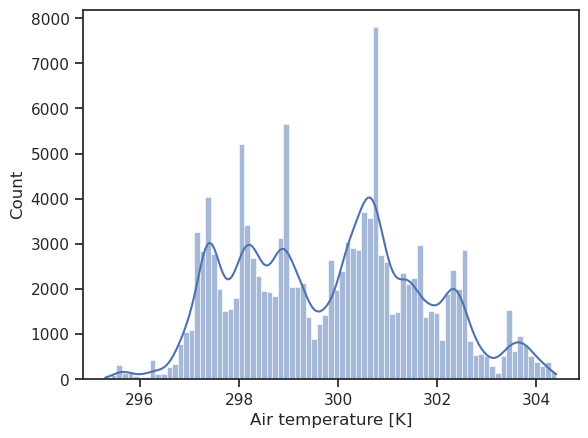

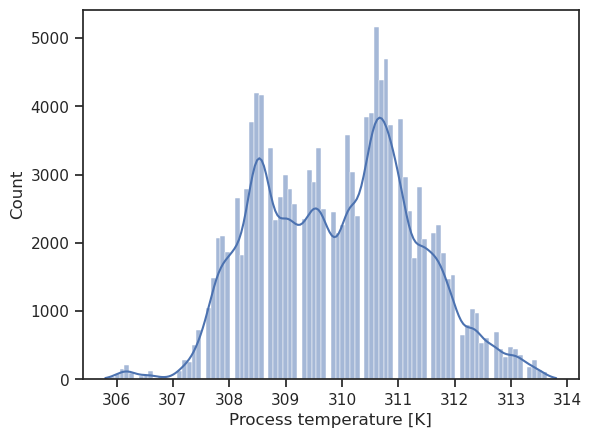

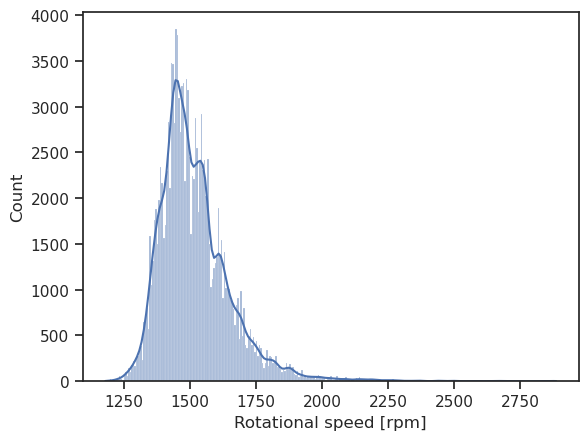

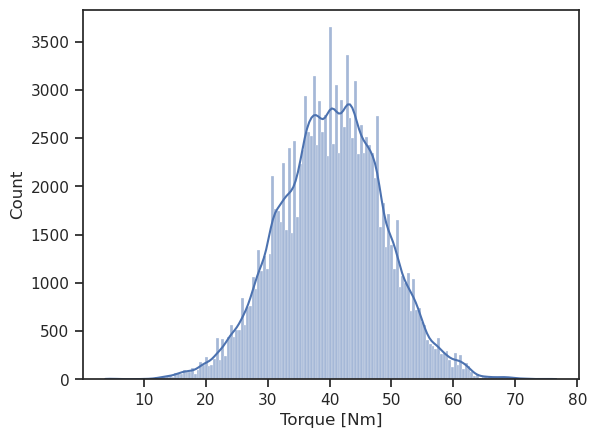

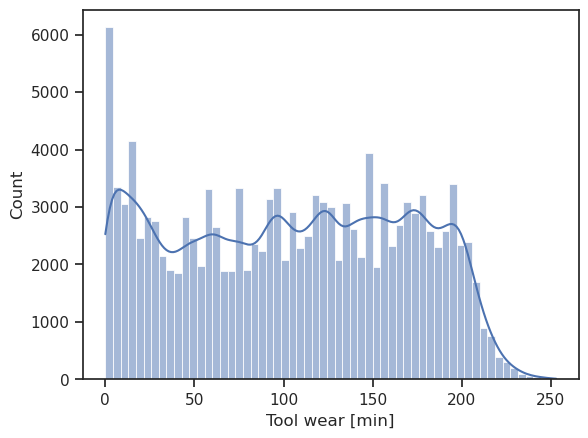

In [9]:
sns.set(style="ticks")

# Subset the numeric data
numeric_data = train_df.iloc[:,1:6]

sns.set(style="ticks")

# Plot the distributions of numeric variables
for column in numeric_data.columns:
    sns.histplot(data=numeric_data, x=column, kde=True)
    plt.show()

# Feature Engineering

First, examining the categorical variables, we can see that if there is any combination of Tool wear failure (TWF), Heat dissipation failure (HDF), Power failure (PWF), or Overstrain failure (OSF), there will be machine failure over 99% of the time:

In [10]:
# Create a new column with default value of 0
train_df['non_random_failure'] = 0

# Set the value to 1 if any of the other columns is 1
train_df.loc[(train_df['TWF'] == 1) | (train_df['HDF'] == 1) | (train_df['PWF'] == 1) | (train_df['OSF'] == 1), 'non_random_failure'] = 1

Rotational speed appears to be skewed to the right, so we will perform a log transformation:

In [11]:
# Perform log transformation
train_df['rotational_speed_log'] = np.log(train_df['Rotational speed [rpm]'])

KDE for tool wear drops significantly around 200, let's account for that:

In [12]:
# Define the threshold value
threshold = 200  # Adjust the threshold value as per your data and observations

# Create a binary indicator variable based on the threshold
train_df['tool_wear_over200'] = (train_df['Tool wear [min]'] > threshold).astype(int)

Get dummies for Type

In [13]:
# Get Dummies
train_df = pd.get_dummies(train_df, columns=['Type'])
train_df.dtypes

Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
non_random_failure           int64
rotational_speed_log       float64
tool_wear_over200            int64
Type_H                       uint8
Type_L                       uint8
Type_M                       uint8
dtype: object

# Model Selection and Training

In [14]:
# Remove special characters and whitespace from feature names
feature_names = train_df.columns.tolist()
feature_names = [re.sub('[^A-Za-z0-9]+', '_', feature) for feature in feature_names]
train_df.columns = feature_names

In [15]:
# Separate features and target variable
X = train_df.drop(columns=['Machine_failure'])
y = train_df['Machine_failure']

# Split the data into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

# Set the hyperparameters for the gradient boosting model
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 99
}

# Train the gradient boosting model
model = lgb.train(params, train_data, num_boost_round=100)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate the model using the AUC-ROC score
auc_score = roc_auc_score(y_val, y_pred)
print('AUC-ROC Score:', auc_score)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
AUC-ROC Score: 0.9648204817772628


# Hyperparamter Tuning

In [16]:
# Define the parameter distributions for random search
param_dist = {
    'num_leaves': sp_randint(20, 41),
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'bagging_freq': sp_randint(3, 6)
}

# Set the hyperparameters for the gradient boosting model
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbose': 0,
    'random_state': 99
}

# Perform random search with cross-validation
model = lgb.LGBMClassifier(**params)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=5)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the model with the best hyperparameters (ignore warnings)
model = lgb.train({**params, **best_params}, train_data, num_boost_round=100)


# Make predictions on the test set
y_pred = model.predict(X_val)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be i

In [17]:
# Evaluate the model using the AUC-ROC score
auc_score = roc_auc_score(y_val, y_pred)
print('AUC-ROC Score:', auc_score)

AUC-ROC Score: 0.9625264158566617


# Prepare Submission

## Perform same feature engineering on test data

In [18]:
# Create a new column with default value of 0
test_df['non_random_failure'] = 0

# Set the value to 1 if any of the other columns is 1
test_df.loc[(test_df['TWF'] == 1) | (test_df['HDF'] == 1) | (test_df['PWF'] == 1) | (test_df['OSF'] == 1), 'non_random_failure'] = 1

# Perform log transformation
test_df['rotational_speed_log'] = np.log(test_df['Rotational speed [rpm]'])

# Define the threshold value
threshold = 200  # Adjust the threshold value as per your data and observations

# Create a binary indicator variable based on the threshold
test_df['tool_wear_over200'] = (test_df['Tool wear [min]'] > threshold).astype(int)

# Get Dummies
test_df = pd.get_dummies(test_df, columns=['Type'])

# Remove special characters and whitespace from feature names
feature_names = test_df.columns.tolist()
feature_names = [re.sub('[^A-Za-z0-9]+', '_', feature) for feature in feature_names]
test_df.columns = feature_names

In [19]:
# Make predictions on test data
test_preds = model.predict(test_df.drop(['id', 'Product_ID'], axis=1))

submission = pd.DataFrame({'id': test_df['id'], 'Machine failure': test_preds})
submission.to_csv('submission.csv', index=False)
submission

,id,Machine failure
0,136429,0.001199
1,136430,0.001758
2,136431,0.000944
3,136432,0.001126
4,136433,0.001360
...,...,...
90949,227378,0.001259
90950,227379,0.000893
90951,227380,0.001081
90952,227381,0.000914
